In [1]:
import numpy as np
import pandas as pd
from ratings_graph import RatingsGraph
from baseline_debiaser import debias_ratings_baseline
import matplotlib.pyplot as plt

## Working Synthetic Data

In [2]:
# Working 2x2 example of synthetic dataset

# num_users, num_entities = 100, 50

# ground_truth_ratings = np.zeros(num_entities)
# ground_truth_ratings[type_1_entities] = 0.3
# ground_truth_ratings[np.logical_not(type_1_entities)] = 0.7

# ratings_matrix = np.zeros((num_users, num_entities))
# ratings_matrix[type_A_users[:, None].dot(type_1_entities[None, :])] = 0.6
# ratings_matrix[type_A_users[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(type_1_entities[None, :])] = 0.1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 0.5

In [3]:
def gen_ratings_graph(rating_sparseness, user_type_counts, entity_type_counts, ground_truth_fn, user_type_ratings):
    '''
    rating_sparseness: percentage of ratings actually present
    user_types_prob: probability that user is type A vs B
    movie_type_prob: probability that movie is type 1 vs 2
    ground_truth: 2x1 matrix, ground truth each type movie
    user_biases: 2x2 matrix with user bias for each movie type
    '''
    num_users, num_entities = np.sum(user_type_counts), np.sum(entity_type_counts)
    ratings_graph = np.random.rand(num_users, num_entities) <= rating_sparseness #0.4
    
    user_types = np.random.permutation(np.repeat(np.arange(user_type_counts.shape[0]), user_type_counts))
    entity_types = np.random.permutation(np.repeat(np.arange(entity_type_counts.shape[0]), entity_type_counts))
    
    ground_truth_ratings = np.vectorize(ground_truth_fn)(entity_types)
    
    ratings_matrix = np.zeros((num_users, num_entities))
    for user_type in range(user_type_counts.shape[0]):
        for entity_type in range(entity_type_counts.shape[0]):
            user_entity_type_mask = (user_types == user_type)[:, None].dot((entity_types == entity_type)[None, :])
            ratings_matrix[user_entity_type_mask] = user_type_ratings(user_type, entity_type)
            
    return ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types

In [51]:
def ground_truth_rating_fn(entity_type):
    return 0.7 if entity_type == 1 else 0.3

def user_type_rating_fn(user_type, entity_type):
    bias = 0.2
    if user_type == 0:
        return ground_truth_rating_fn(entity_type) + 0.2
    else:
        return ground_truth_rating_fn(entity_type) - 0.3

ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types = gen_ratings_graph(0.4, (1000*np.array([0.9, 0.1])).astype(int), \
                                                                        (500*np.array([0.5, 0.5])).astype(int), \
                                                                        ground_truth_rating_fn,
                                                                        user_type_rating_fn)
synthetic_graph = RatingsGraph(ratings_graph, ratings_matrix, ground_truth_ratings=ground_truth_ratings)
biases, true_ratings, errors = debias_ratings_baseline(synthetic_graph, 0.99, 1000)

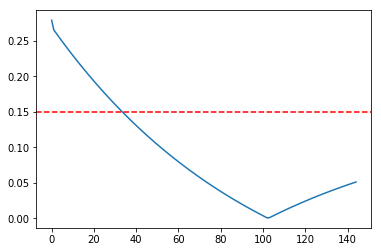

In [52]:
mean_pred = np.mean(ratings_matrix, axis=0)
mean_pred_error = np.sqrt(np.mean((mean_pred - ground_truth_ratings)**2))

plt.plot(errors)
plt.axhline(mean_pred_error, color='r', linestyle='--')
plt.show()

In [53]:
best_iter = np.argmin(errors)
#true_ratings[best_iter]
print(best_iter)
np.sort(np.abs(biases[best_iter - 1] - biases[best_iter]))

102


array([0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153419,
       0.00153419, 0.00153419, 0.00153419, 0.00153419, 0.00153

In [54]:
ground_truth_ratings

array([0.7, 0.7, 0.3, 0.3, 0.7, 0.3, 0.7, 0.3, 0.7, 0.3, 0.3, 0.7, 0.3,
       0.7, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7,
       0.7, 0.7, 0.3, 0.7, 0.3, 0.3, 0.7, 0.7, 0.3, 0.7, 0.7, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7,
       0.3, 0.3, 0.3, 0.7, 0.3, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.7, 0.3,
       0.3, 0.7, 0.3, 0.3, 0.7, 0.7, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7,
       0.3, 0.3, 0.3, 0.7, 0.7, 0.7, 0.3, 0.3, 0.3, 0.7, 0.7, 0.7, 0.7,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.3, 0.3, 0.3, 0.7, 0.7, 0.7,
       0.3, 0.7, 0.7, 0.7, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.3, 0.3, 0.3,
       0.7, 0.7, 0.7, 0.7, 0.3, 0.3, 0.7, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7,
       0.3, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.3,
       0.7, 0.7, 0.7, 0.3, 0.3, 0.3, 0.7, 0.3, 0.3, 0.3, 0.7, 0.7, 0.7,
       0.7, 0.3, 0.7, 0.3, 0.3, 0.7, 0.7, 0.7, 0.3, 0.3, 0.7, 0.

In [8]:
biases

[array([0.93482505, 0.71195872, 0.7913154 , 0.8455285 , 0.75319556,
        0.91890819, 0.58021101, 0.8201265 , 0.88769001, 0.27083927,
        0.0410858 , 0.41595956, 0.45278609, 0.52776085, 0.45658971,
        0.20208213, 0.45034651, 0.42471765, 0.78691115, 0.3307115 ,
        0.15142099, 0.41377656, 0.50436359, 0.97711509, 0.8913427 ,
        0.79452406, 0.38197925, 0.93529377, 0.07478095, 0.29037558,
        0.6841753 , 0.4104284 , 0.90703038, 0.71326588, 0.74226344,
        0.68560392, 0.95865122, 0.50544507, 0.02166306, 0.36873641,
        0.76720391, 0.25535349, 0.80017964, 0.82722668, 0.00530984,
        0.90985137, 0.97115091, 0.32613005, 0.09953624, 0.55020491,
        0.87656274, 0.42186668, 0.01081215, 0.99988068, 0.46287161,
        0.85793137, 0.03474818, 0.61481703, 0.82271803, 0.18052157,
        0.23936245, 0.64036569, 0.97907696, 0.29299529, 0.0577023 ,
        0.51874453, 0.11759148, 0.61218821, 0.24974089, 0.67206053,
        0.17555928, 0.94881144, 0.91832961, 0.83